model 3 is our main model

In [138]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.metrics import MeanSquaredError, MeanAbsoluteError
import seaborn as sns

In [139]:
tech_list = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG'] #^GSPC is the S&P 500

end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = datetime(end.year - 1, end.month, end.day)

# Downloading data for each stock and storing it in a dictionary
stock_data = {}
for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end)


for stock in stock_data:
    stock_data[stock].rename(columns={"Adj Close": "Adjusted Close"}, inplace=True)

# Assigning each DataFrame to a variable for convenience
SP500 = stock_data['^GSPC']
AAPL = stock_data['AAPL']
MSFT = stock_data['MSFT']
AMZN = stock_data['AMZN']
NVDA = stock_data['NVDA']
GOOGL = stock_data['GOOGL']
TSLA = stock_data['TSLA']
GOOG = stock_data['GOOG']

# Adding company_name to each DataFrame and concatenating them
company_list = [SP500, AAPL, MSFT, AMZN, NVDA, GOOGL, TSLA, GOOG]
company_name = ["SP500", "APPLE", "MICROSOFT", "AMAZON", "NVIDIA", "GOOGLE", "TESLA", "ALPHABET"]

for df, com_name in zip(company_list, company_name):
    df["company_name"] = com_name

# Concatenating all DataFrames
df = pd.concat(company_list, axis=0)

print(df['company_name'].unique())
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

['SP500' 'APPLE' 'MICROSOFT' 'AMAZON' 'NVIDIA' 'GOOGLE' 'TESLA' 'ALPHABET']
                  Open        High         Low       Close  Adjusted Close  \
Date                                                                         
2024-07-25  174.250000  175.199997  169.050003  169.160004      169.160004   
2024-07-26  168.770004  169.839996  165.865005  168.679993      168.679993   
2024-07-29  170.500000  172.160004  169.720001  171.130005      171.130005   
2024-07-30  171.830002  172.949997  170.119995  171.860001      171.860001   
2024-07-31  174.919998  175.910004  171.720001  173.149994      173.149994   
2024-08-01  171.979996  175.679993  170.509995  172.449997      172.449997   
2024-08-02  168.190002  170.210007  166.389999  168.399994      168.399994   
2024-08-05  157.369995  165.940002  156.600006  160.639999      160.639999   
2024-08-06  160.945007  162.350006  158.130005  160.539993      160.539993   
2024-08-07  163.240005  164.789993  160.240005  160.750000      16

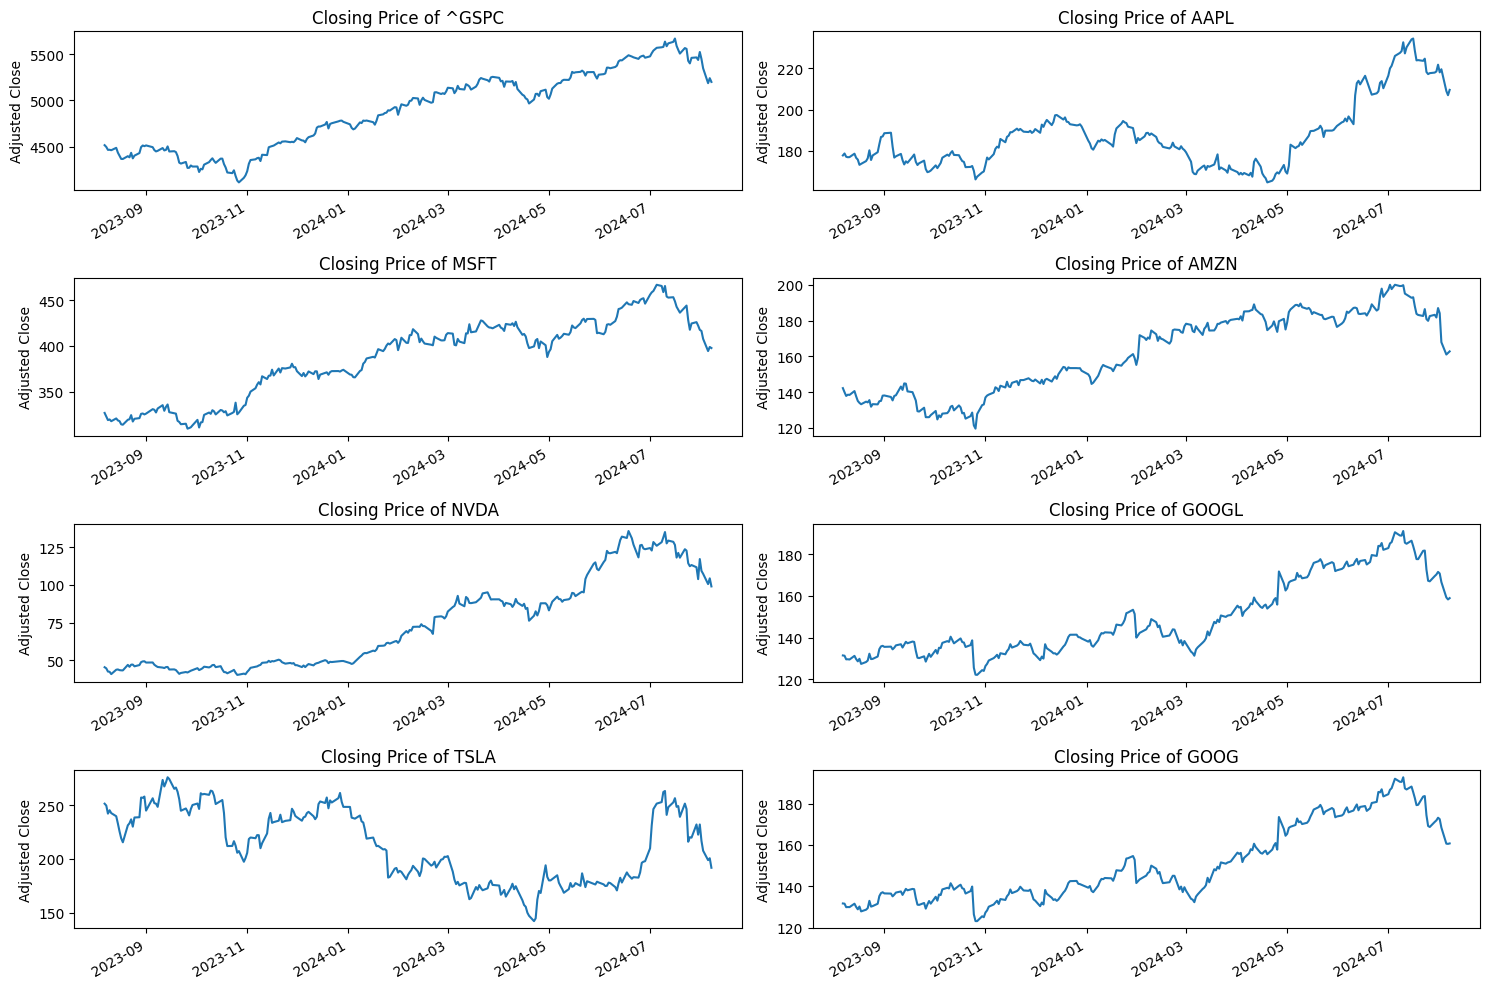

In [140]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(4, 2, i)
    company['Adjusted Close'].plot()
    plt.ylabel('Adjusted Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

1. **General Upward Trend (November 2023 - June 2024):**
   - **Stocks and Index:** All displayed a general upward trend during this period.

2. **Peak (Around July 2024):**
   - **Stocks and Index:** All three stocks and the S&P 500 index reached their respective peaks around July 2024.

3. **Post-Peak Decline:**
   - **Stocks and Index:** After peaking in July 2024, all stocks and the S&P 500 index experienced a notable decline.

4. **Trend Similarity:**
   - **Microsoft & S&P 500:** Among the stocks, Microsoft's trend was the most similar to that of the S&P 500 index.


In [141]:
# Fetch the adjusted closing prices for the tech stocks
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', '^GSPC']
closing_df = yf.download(tickers, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  8 of 8 completed


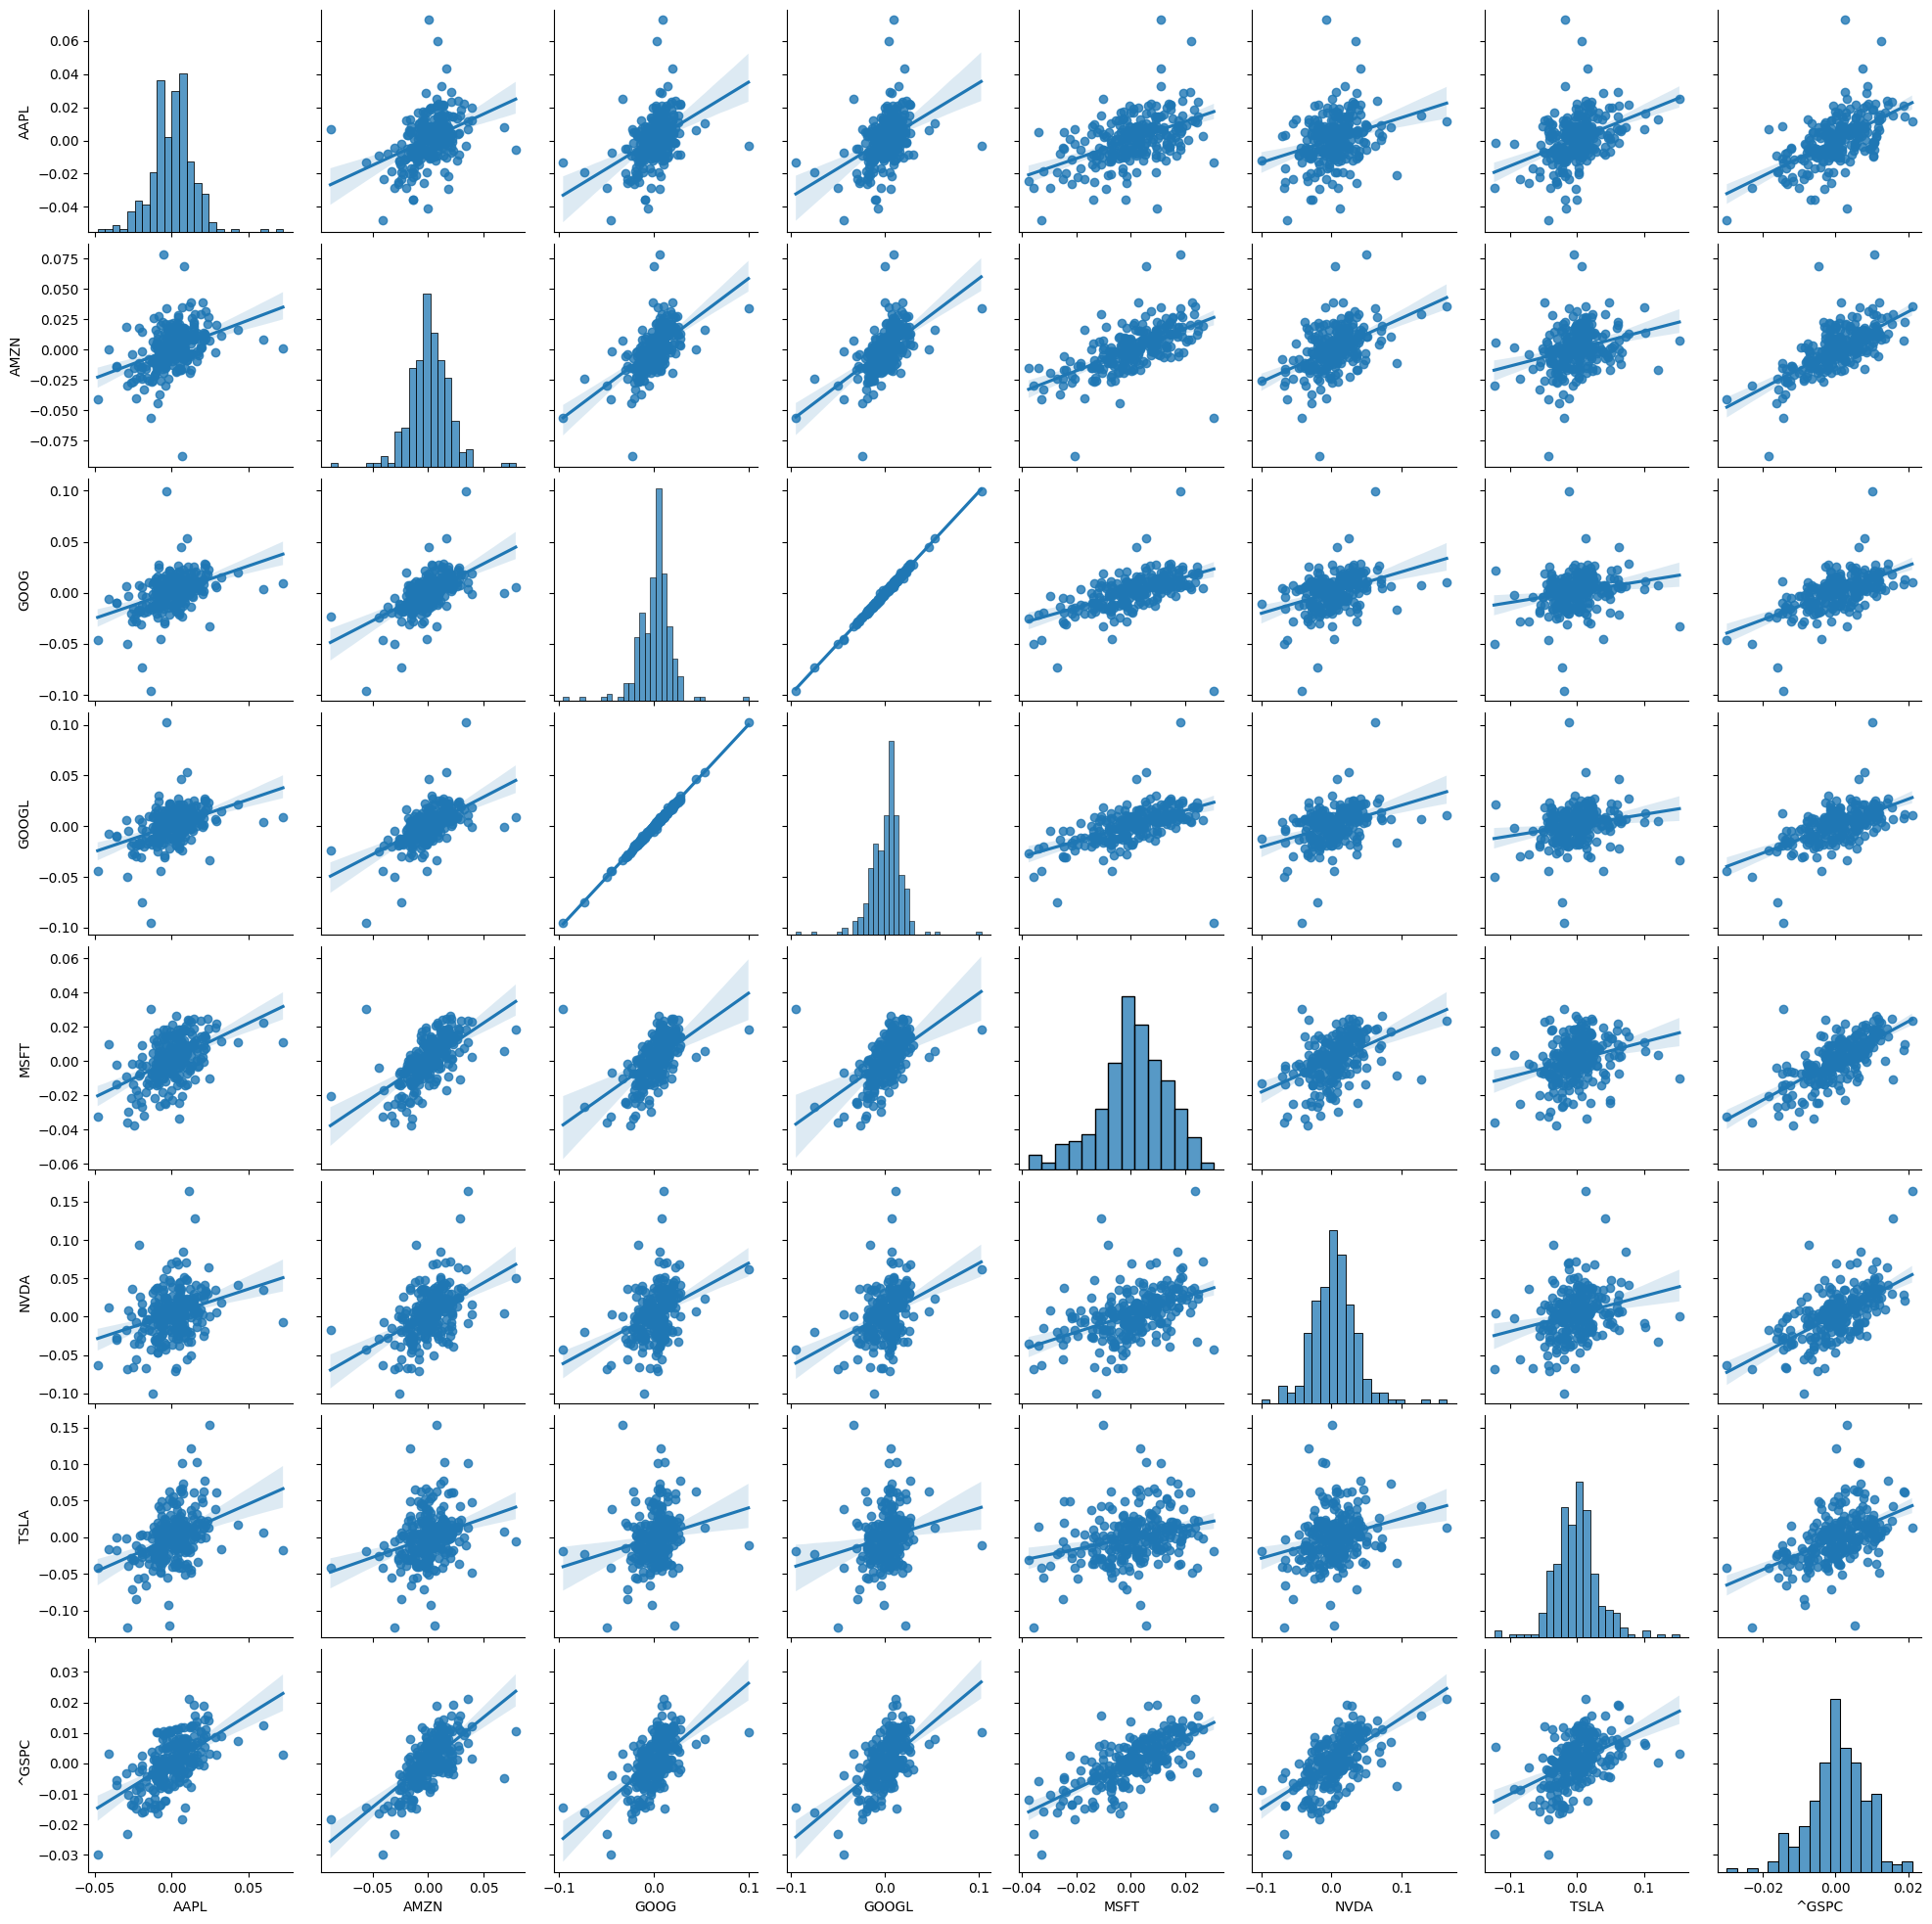

In [142]:
sns.pairplot(tech_rets, kind='reg')

Text(0.5, 1.0, 'Correlation of stock daily return')

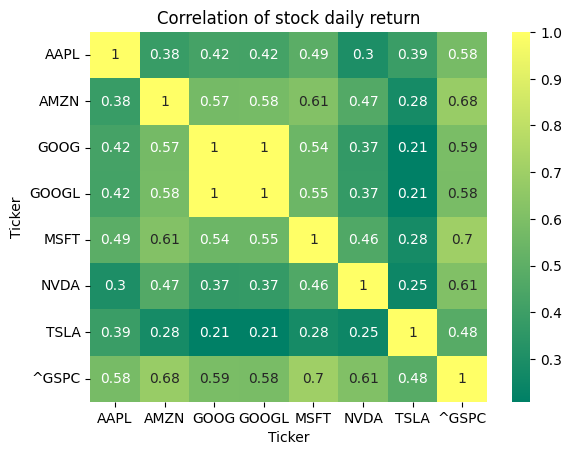

In [143]:
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock daily return')

We can see that our target is correlated (above 0.48) with the daily return of these stocks, and Microsoft is the most correlated one. Let's visualize the daily return percentages (the 3 most correlated stocks with the S&P 500)

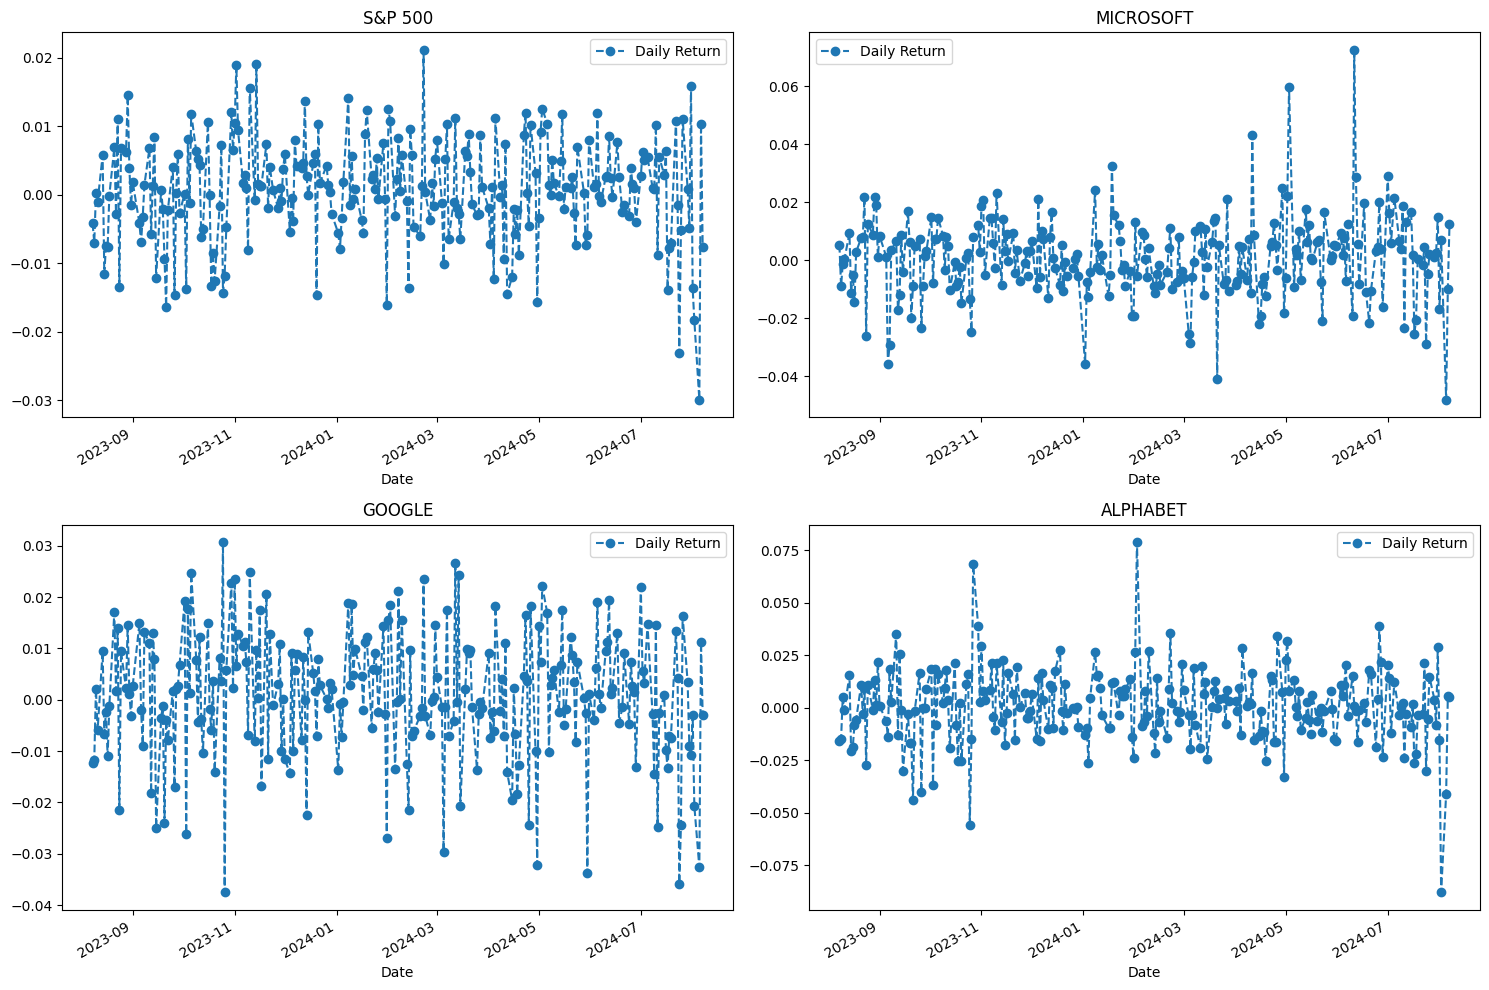

In [144]:
for company in company_list:
    company['Daily Return'] = company['Adjusted Close'].pct_change()

# Plotting the daily return percentages
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

SP500['Daily Return'].plot(ax=axes[0, 0], legend=True, linestyle='--', marker='o')
axes[0, 0].set_title('S&P 500')

AAPL['Daily Return'].plot(ax=axes[0, 1], legend=True, linestyle='--', marker='o')
axes[0, 1].set_title('MICROSOFT')

MSFT['Daily Return'].plot(ax=axes[1, 0], legend=True, linestyle='--', marker='o')
axes[1, 0].set_title('GOOGLE')

AMZN['Daily Return'].plot(ax=axes[1, 1], legend=True, linestyle='--', marker='o')
axes[1, 1].set_title('ALPHABET')

fig.tight_layout()
plt.show()

Let's now to fetch the daily return of these stocks and use them as features to train our model.

In [145]:
end = end
start = '2000-01-01'

# Fetch adjusted close prices for Apple, Amazon, and Microsoft...
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG' ]
data = {}

for ticker in tickers:
    stock_data = yf.download(ticker, start=start, end=end)
    adj_close = stock_data['Adj Close']
    data[ticker] = adj_close.rename(ticker)

# Merge the data into a single DataFrame
merged_data = pd.concat(data.values(), axis=1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [146]:
merged_data.dropna(inplace=True)

for column in merged_data.columns:
    merged_data[f'{column} DR'] = merged_data[column].pct_change()

merged_data.dropna(inplace=True)

print(merged_data.head())


                AAPL    AMZN       MSFT      NVDA      GOOGL      TSLA  \
Date                                                                     
2010-06-30  7.586103  5.4630  17.517599  0.234122  11.122120  1.588667   
2010-07-01  7.494112  5.5480  17.631786  0.238020  10.985640  1.464000   
2010-07-02  7.447668  5.4570  17.715527  0.235039  10.912151  1.280000   
2010-07-06  7.498641  5.5030  18.134241  0.232517  10.900153  1.074000   
2010-07-07  7.801443  5.6715  18.499670  0.243753  11.253350  1.053333   

                 GOOG   AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR  \
Date                                                                      
2010-06-30  11.069613 -0.018112  0.005985 -0.012870 -0.025763 -0.020495   
2010-07-01  10.933779 -0.012126  0.015559  0.006518  0.016650 -0.012271   
2010-07-02  10.860637 -0.006197 -0.016402  0.004749 -0.012524 -0.006689   
2010-07-06  10.848695  0.006844  0.008430  0.023635 -0.010731 -0.001100   
2010-07-07  11.200226  0.040381

In [147]:
#keep only the daily return columns
columns_to_drop = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA',  'GOOG']
data = {}

merged_data.drop(columns=columns_to_drop, inplace=True)

print(merged_data.head())

             AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR   TSLA DR  \
Date                                                                     
2010-06-30 -0.018112  0.005985 -0.012870 -0.025763 -0.020495 -0.002511   
2010-07-01 -0.012126  0.015559  0.006518  0.016650 -0.012271 -0.078473   
2010-07-02 -0.006197 -0.016402  0.004749 -0.012524 -0.006689 -0.125683   
2010-07-06  0.006844  0.008430  0.023635 -0.010731 -0.001100 -0.160937   
2010-07-07  0.040381  0.030620  0.020151  0.048324  0.032403 -0.019243   

             GOOG DR  
Date                  
2010-06-30 -0.020495  
2010-07-01 -0.012271  
2010-07-02 -0.006690  
2010-07-06 -0.001100  
2010-07-07  0.032403  


Fetch the sp500 data from yahoo finance and add some technical indicators as well.

1. **Relative Strength Index (RSI):** Measures momentum and helps identify overbought or oversold conditions, which can signal potential reversals.

2. **Exponential Moving Averages (EMA - Fast, Medium, Slow):** Highlight short-term, medium-term, and long-term trends by giving more weight to recent prices, helping to track market direction over different time horizons.

3. **Simple Moving Averages (SMA - 30, 100):** Provide a smoothed view of price trends over different periods, aiding in trend identification and potential reversal points.

4. **Bollinger Bands (High/Low):** Measure market volatility and potential breakout points, helping the model understand periods of high or low volatility.

5. **Average True Range (ATR):** Gauges market volatility by considering price ranges, which is crucial for understanding market dynamics and potential price movements.

6. **Moving Average Convergence Divergence (MACD):** Captures momentum and trend direction, highlighting potential buy or sell signals based on the convergence and divergence of moving averages.

Including these indicators enriches the feature set, allowing the model to capture various aspects of market behavior such as trend, momentum, and volatility.

In [148]:
end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = '2000-01-01'

sp500_data = yf.download('^GSPC', start=start, end=end)


# Add technical indicators
sp500_data['Rsi'] = ta.rsi(sp500_data['Adj Close'], length=14)  
sp500_data['Ema_fast'] = ta.ema(sp500_data['Adj Close'], length=12)  
sp500_data['Ema_medium'] = ta.ema(sp500_data['Adj Close'], length=26)  
sp500_data['Ema_slow'] = ta.ema(sp500_data['Adj Close'], length=50) 
sp500_data['Sma_30'] = ta.sma(sp500_data['Adj Close'], length=30)  
sp500_data['Sma_100'] = ta.sma(sp500_data['Adj Close'], length=100)  

sp500_data['Bollinger_High'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBU_20_2.0']
sp500_data['Bollinger_Low'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBL_20_2.0']

sp500_data['ATR'] = ta.atr(sp500_data['High'], sp500_data['Low'], sp500_data['Adj Close'], length=14)
sp500_data['MACD'] = ta.macd(sp500_data['Adj Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']

print(sp500_data.head(7))

[*********************100%%**********************]  1 of 1 completed


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   
2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976  1457.599976   
2000-01-11  1457.599976  1458.660034  1434.420044  1438.560059  1438.560059   

                Volume  Rsi  Ema_fast  Ema_medium  Ema_slow  Sma_30  Sma_100  \
Date                                                                           
2000-01-03   931800000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-04  1009000000  NaN       NaN         Na

Notice Date is the index, and weekends are missing.

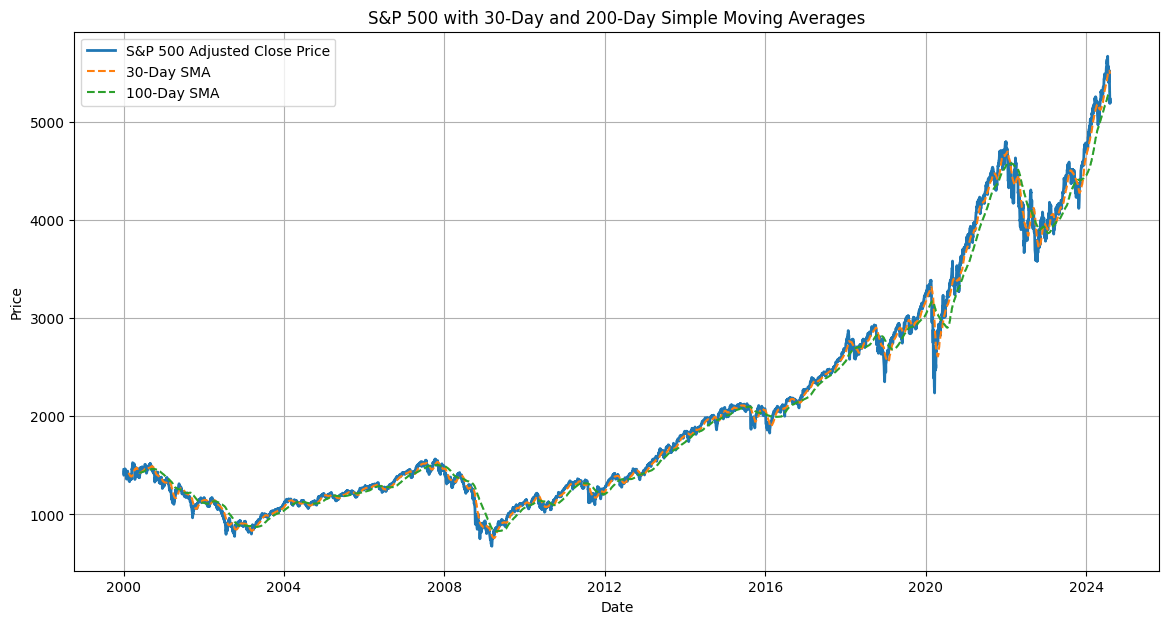

In [149]:
plt.figure(figsize=(14, 7))
plt.plot(sp500_data['Adj Close'], label='S&P 500 Adjusted Close Price', linewidth=2)
plt.plot(sp500_data['Sma_30'], label='30-Day SMA', linestyle='--', linewidth=1.5)
plt.plot(sp500_data['Sma_100'], label='100-Day SMA', linestyle='--', linewidth=1.5)
plt.title('S&P 500 with 30-Day and 200-Day Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

We can see both the 30-day and 100-day Simple Moving Averages (SMAs) capturing the overall trend of the S&P 500 well.

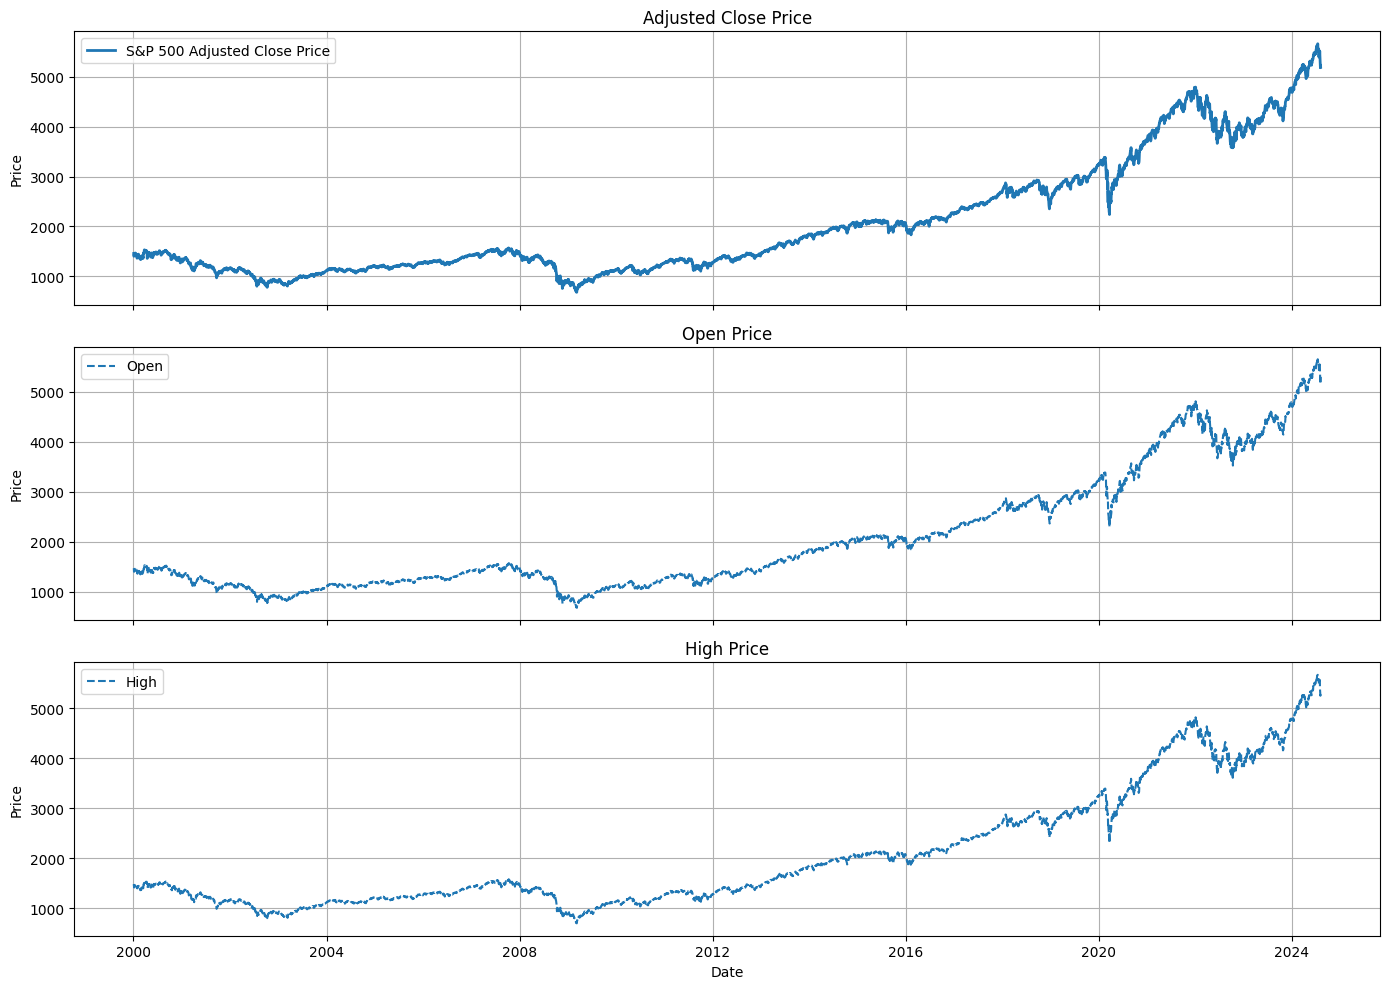

In [150]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Adjusted Close Price
axs[0].plot(sp500_data.index, sp500_data['Adj Close'], label='S&P 500 Adjusted Close Price', linewidth=2)
axs[0].set_title('Adjusted Close Price')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid(True)

# Open Price
axs[1].plot(sp500_data.index, sp500_data['Open'], label='Open', linestyle='--', linewidth=1.5)
axs[1].set_title('Open Price')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid(True)

# High Price
axs[2].plot(sp500_data.index, sp500_data['High'], label='High', linestyle='--', linewidth=1.5)
axs[2].set_title('High Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [151]:
merged_data = pd.concat([sp500_data, merged_data], axis=1).dropna()

print(merged_data.shape)
print(merged_data.columns)

(3550, 23)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR'],
      dtype='object')


Let's check the correlation between economic features and our target to determine if they should be included to improve our model's performance.

In [152]:
# Fetch economic data
gdp = pdr.get_data_fred('GDP', start=start, end=end) #quaterly
inflation = pdr.get_data_fred('CPIAUCSL', start=start, end=end)  # CPI for inflation
unemployment = pdr.get_data_fred('UNRATE', start=start, end=end)
interest_rate = pdr.get_data_fred('FEDFUNDS', start=start, end=end)

# Rename columns for clarity
gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True)
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)
GDP = gdp.resample('D').ffill()
Inflation = inflation.resample('D').ffill()
Unemployment = unemployment.resample('D').ffill()
Interest_rate = interest_rate.resample('D').ffill()

merged_data = merged_data.join([Inflation, Unemployment, Interest_rate, GDP], how='left')

print(merged_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Inflation',
       'Unemployment', 'Interest_Rate', 'GDP'],
      dtype='object')


Adding lagged features allows the model to capture temporal dependencies and trends in the data, improving its ability to recognize patterns over time. By incorporating historical values, such as lagged 'Adj Close', 'Rsi', and 'MACD', we wish to enhance the model's predictive power and capture the underlying dynamics of the stock market.

In [153]:
n_lags = 3
for col in ['Adj Close', 'Rsi', 'MACD']:
    for lag in range(1, n_lags + 1):
        merged_data[f'{col}_lag_{lag}'] = merged_data[col].shift(lag)


merged_data['Target'] = merged_data['Adj Close'].pct_change()

merged_data.dropna(inplace=True)
merged_data.reset_index(inplace = True)
Date = merged_data['Date']
merged_data.drop([ 'Date', 'Volume'], axis=1, inplace=True)
print(merged_data.head())

          Open         High          Low        Close    Adj Close        Rsi  \
0  1028.089966  1042.500000  1018.349976  1028.060059  1028.060059  32.767748   
1  1028.540039  1060.890015  1028.540039  1060.270020  1060.270020  45.156109   
2  1062.920044  1071.250000  1058.239990  1070.250000  1070.250000  48.332802   
3  1070.500000  1078.160034  1068.099976  1077.959961  1077.959961  50.708161   
4  1077.229980  1080.780029  1070.449951  1078.750000  1078.750000  50.956973   

      Ema_fast   Ema_medium     Ema_slow       Sma_30  ...  Adj Close_lag_1  \
0  1055.252067  1076.029172  1097.563245  1077.334996  ...      1022.580017   
1  1056.024059  1074.861827  1096.100766  1076.888995  ...      1028.060059   
2  1058.212666  1074.520210  1095.087010  1076.762994  ...      1060.270020   
3  1061.250711  1074.775007  1094.415361  1077.096661  ...      1070.250000   
4  1063.942909  1075.069450  1093.801033  1076.286326  ...      1077.959961   

   Adj Close_lag_2  Adj Close_lag_3  R

<Axes: >

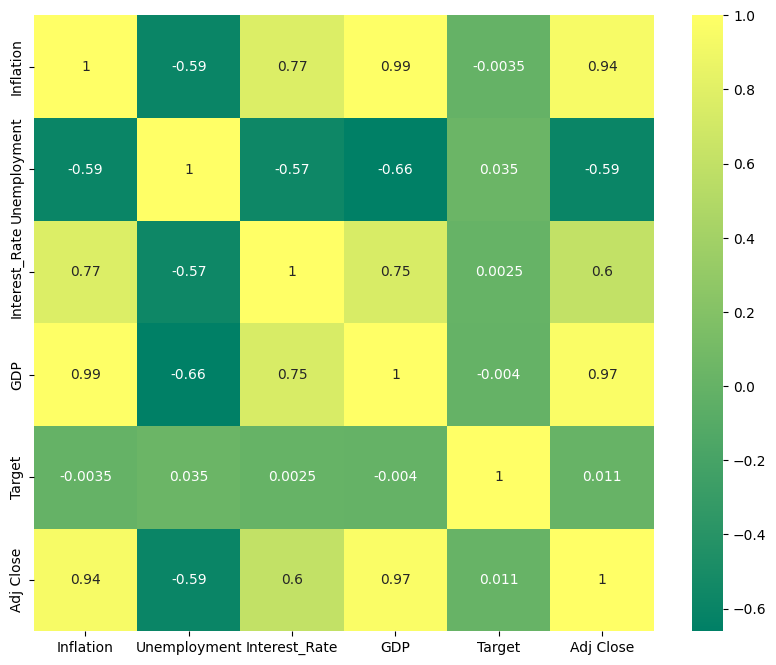

In [154]:
dd = merged_data[['Inflation', 'Unemployment', 'Interest_Rate', 'GDP', 'Target', 'Adj Close']]

plt.figure(figsize=(10, 8))
sns.heatmap(dd.corr(), annot=True, cmap='summer')

We can see these economic features are not correlated with our target, so we will not include them in our model.

In [155]:
merged_data.drop(['Inflation', 'Unemployment', 'Interest_Rate', 'GDP'], axis=1, inplace=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             3458 non-null   float64
 1   High             3458 non-null   float64
 2   Low              3458 non-null   float64
 3   Close            3458 non-null   float64
 4   Adj Close        3458 non-null   float64
 5   Rsi              3458 non-null   float64
 6   Ema_fast         3458 non-null   float64
 7   Ema_medium       3458 non-null   float64
 8   Ema_slow         3458 non-null   float64
 9   Sma_30           3458 non-null   float64
 10  Sma_100          3458 non-null   float64
 11  Bollinger_High   3458 non-null   float64
 12  Bollinger_Low    3458 non-null   float64
 13  ATR              3458 non-null   float64
 14  MACD             3458 non-null   float64
 15  AAPL DR          3458 non-null   float64
 16  AMZN DR          3458 non-null   float64
 17  MSFT DR       

In [156]:
features= merged_data.drop(['Target'], axis=1)
features = features.columns
print(features)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3'],
      dtype='object')


Since we have a large number of features, some of which are highly correlated, we will perform Principal Component Analysis (PCA) to reduce the dimensionality of our data. Because PCA is sensitive to the scale of the data, we will first standardize the features before applying PCA. After dimensionality reduction, we will fit an LSTM model to the transformed data.

In [157]:
x = merged_data.loc[:, features].values
y = merged_data.loc[:,['Target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [158]:
pd.DataFrame(data = x, columns = features).head()

Open      High       Low     Close  Adj Close       Rsi  Ema_fast  \
0 -1.465795 -1.457302 -1.469557 -1.466121  -1.466121 -2.043697 -1.440759   
1 -1.465383 -1.440568 -1.460177 -1.436651  -1.436651 -0.936758 -1.440050   
2 -1.433921 -1.431142 -1.432837 -1.427521  -1.427521 -0.652911 -1.438040   
3 -1.426985 -1.424854 -1.423761 -1.420466  -1.420466 -0.440665 -1.435250   
4 -1.420826 -1.422470 -1.421598 -1.419744  -1.419744 -0.418433 -1.432777   

   Ema_medium  Ema_slow    Sma_30  ...   GOOG DR  Adj Close_lag_1  \
0   -1.420562 -1.397795 -1.418138  ... -0.117281        -1.470775   
1   -1.421639 -1.399153 -1.418550  ...  1.829241        -1.465758   
2   -1.421954 -1.400095 -1.418667  ...  0.767393        -1.436273   
3   -1.421719 -1.400719 -1.418359  ...  1.337526        -1.427138   
4   -1.421447 -1.401289 -1.419107  ...  0.983115        -1.420080   

   Adj Close_lag_2  Adj Close_lag_3  Rsi_lag_1  Rsi_lag_2  Rsi_lag_3  \
0        -1.466040        -1.462631  -2.263661  -2.177838  -2.118851   
1        -1.470427        -1.465691  -2.041491  -2.261520  -2.175825   
2        -1.465408        -1.470081  -0.935262  -2.039470  -2.259464   
3        -1.435908        -1.465059  -0.651597  -0.933836  -2.037528   
4        -1.426768        -1.435543  -0.439487  -0.650324  -0.932464   

   MACD_lag_1  MACD_lag_2  MACD_lag_3  
0   -0.904396   -0.830440   -0.743801  
1   -0.940429   -0.903940   -0.830003  
2   -0.877273   -0.939983   -0.903525  
3   -0.794874   -0.876810   -0.939579  
4   -0.704236   -0.794388   -0.876387  

[5 rows x 31 columns]

In [159]:
pca = PCA(n_components=10)  
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_

array([0.50168872, 0.210863  , 0.13721486, 0.03722736, 0.02710949,
       0.02002891, 0.01626361, 0.01586561, 0.01179781, 0.0095271 ])

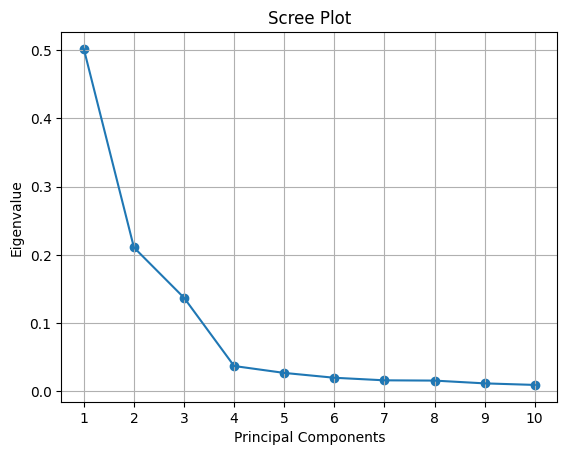

In [160]:
# Explained variance ratio
importance = pca.explained_variance_ratio_

# Scree plot
plt.scatter(range(1, len(importance) + 1), importance)
plt.plot(range(1, len(importance) + 1), importance)
plt.title('Scree Plot')
plt.xlabel('Principal Components')  
plt.ylabel('Eigenvalue')  
plt.xticks(range(1, len(importance) + 1))
plt.grid(True)
plt.show()

In [161]:
pca = PCA(n_components=3) 
principalComponents = pca.fit_transform(x)
print(sum(pca.explained_variance_ratio_))

0.8497665834038531


By look at the ratio and the plot, 3 principal components can explain 85% of the variance in the data.

In [162]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, merged_data[['Target']]], axis = 1)

finalDf.head(5)

PC1       PC2       PC3    Target
0 -5.860558 -3.712899 -0.656241  0.005359
1 -5.841506 -3.204735  3.893132  0.031331
2 -5.802316 -2.723477  1.545873  0.009413
3 -5.729780 -2.043894  1.300529  0.007204
4 -5.669946 -1.385848  1.581690  0.000733

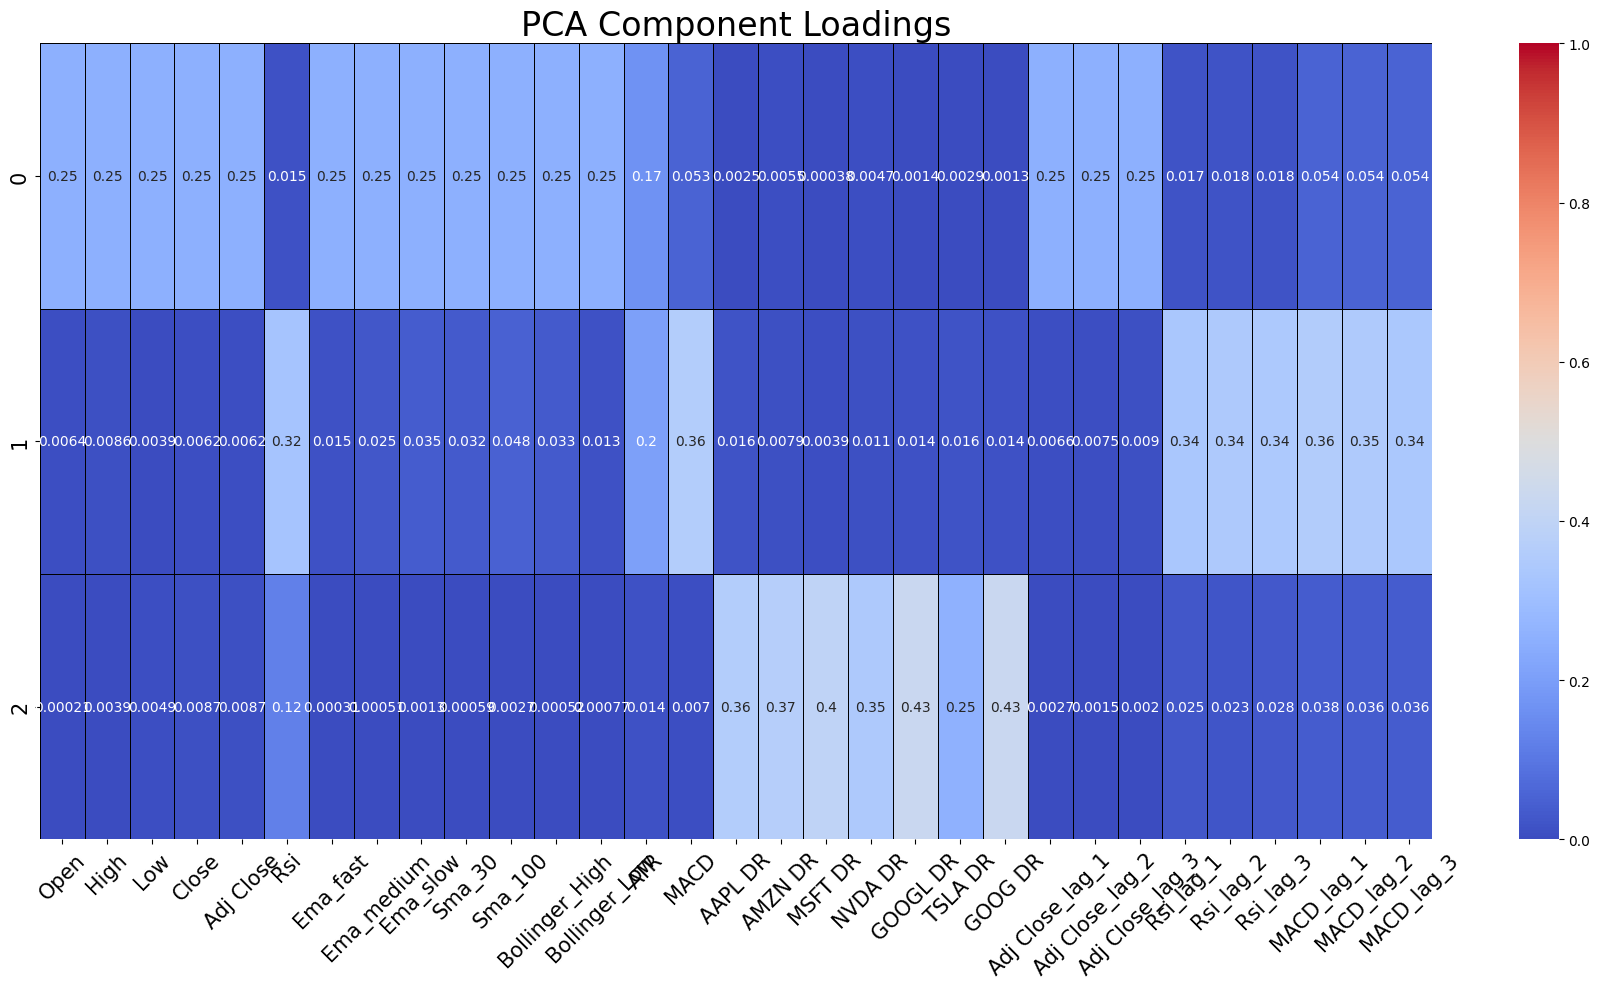

In [163]:
df_cm = pd.DataFrame(np.abs(pca.components_), columns=merged_data.columns[:-1])
plt.figure(figsize=(18, 10))  
ax = sns.heatmap(df_cm, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='black', vmin=0, vmax=1, annot_kws={"size": 10})
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15, rotation=45) 
plt.title('PCA Component Loadings', fontsize=24)
plt.tight_layout()  
plt.show()  


Let's perform LSTM on the data and evaluate its performance. Before standardizing the data, we will split it into training and testing sets to prevent data leakage.

In [164]:
splitlimit = int(finalDf.shape[0] * 0.8)
trainDf, testDf = finalDf[:splitlimit], finalDf[splitlimit:]

# Standardize the data excluding the target column 
sc = StandardScaler()
trainDf_scaled = sc.fit_transform(trainDf.iloc[:, :-1])#exclude the target column
testDf_scaled = sc.transform(testDf.iloc[:, :-1])

# Prepare the sequences for LSTM
backcandles = 30


X_train = []
X_test = []

for j in range(trainDf_scaled.shape[1]):  # loop over features
    temp_train = []
    for i in range(backcandles, len(trainDf_scaled)):
        temp_train.append(trainDf_scaled[i-backcandles:i, j])
    X_train.append(temp_train)


for j in range(testDf_scaled.shape[1]):  # loop over features
    temp_test = []
    for i in range(backcandles, len(testDf_scaled)):
        temp_test.append(testDf_scaled[i-backcandles:i, j])
    X_test.append(temp_test)

# Convert lists to numpy arrays and move axes
X_train = np.moveaxis(np.array(X_train), 0, 2)
X_test = np.moveaxis(np.array(X_test), 0, 2)

# Extract target variables assuming target is in the last column
y_train = np.array(trainDf.iloc[backcandles:, -1])
y_test = np.array(testDf.iloc[backcandles:, -1])

# Reshape targets to (samples, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Output shapes for verification
print("Training Data Shape:", X_train.shape)
print("Training Target Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Target Shape:", y_test.shape)


Training Data Shape: (2736, 30, 3)
Training Target Shape: (2736, 1)
Test Data Shape: (662, 30, 3)
Test Target Shape: (662, 1)


We attempted grid search, but it took too long to run and required more memory than we have available. Therefore, let's try using random search instead.

We will first use Bayesian Optimization for hyperparameter tuning, which is a powerful technique that efficiently searches the hyperparameter space to find the optimal values for our LSTM model. Bayesian Optimization tends to be faster compared to traditional methods like grid search or random search.

The model that performs best during this optimization process will be referred to as "best model 1."

best_model1

Reloading Tuner from tuner_data/lstm_tuning/tuner0.json


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.8667e-04 - mean_absolute_error: 0.0101 - mean_squared_error: 1.8667e-04 - val_loss: 2.6658e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.6658e-04 - learning_rate: 0.0033
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0873e-04 - mean_absolute_error: 0.0075 - mean_squared_error: 1.0873e-04 - val_loss: 2.6810e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 2.6810e-04 - learning_rate: 0.0033
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.9899e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 9.9899e-05 - val_loss: 2.6726e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 2.6726e-04 - learning_rate: 0.0033
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.5648e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 9.5648e-05 - val_loss: 2.6264e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 2.6264e-04 - learning_rate: 0.0

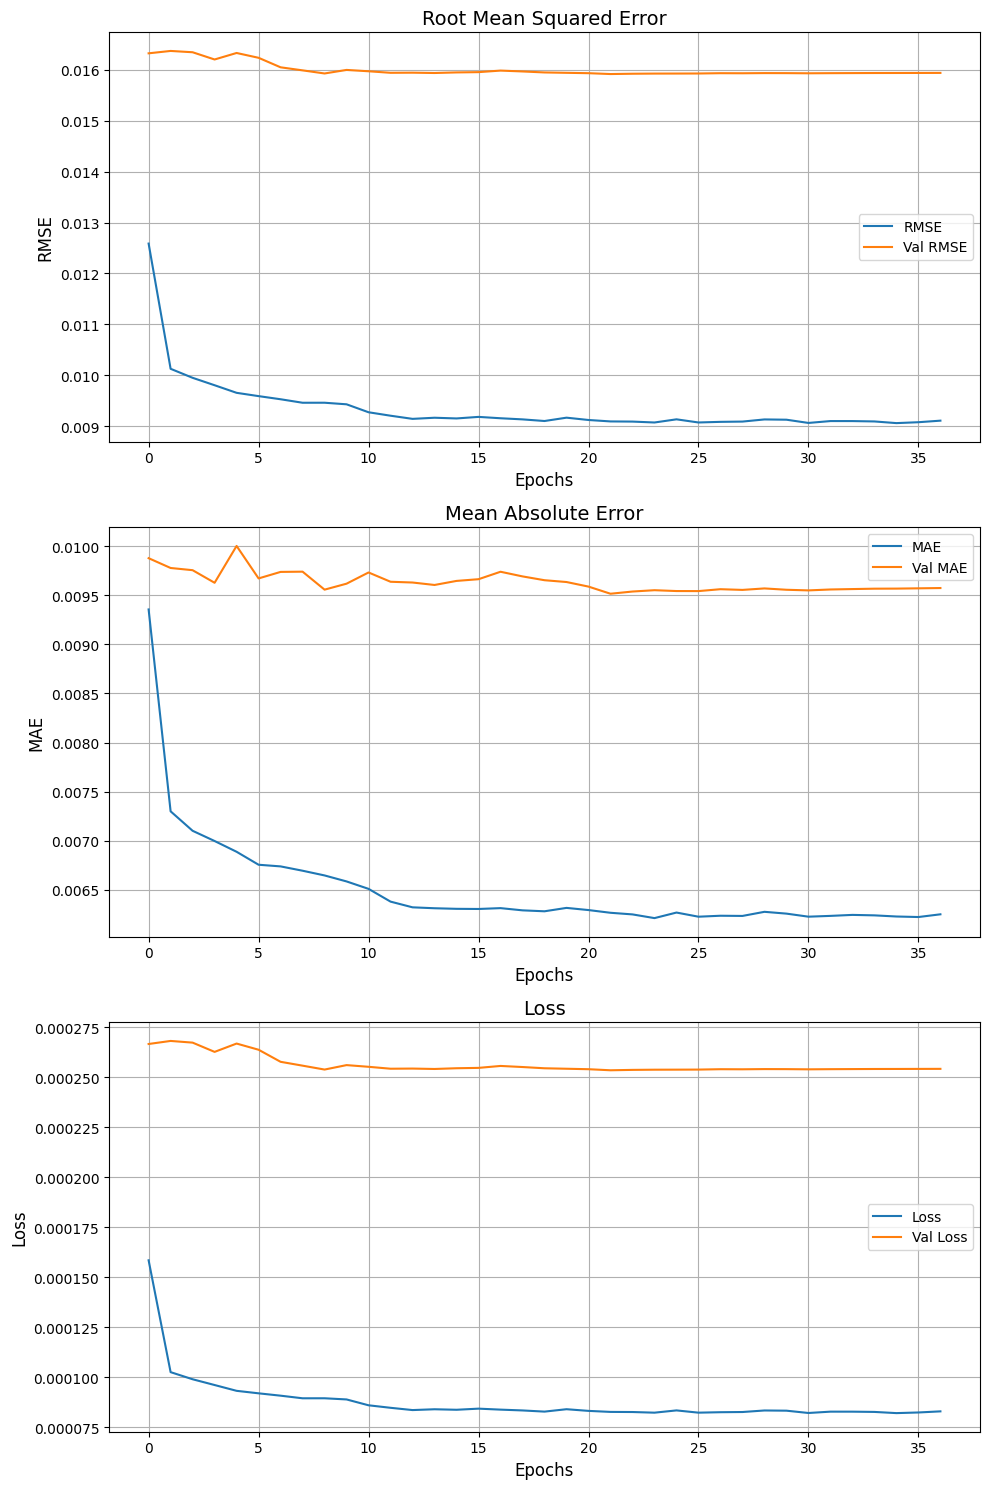

In [ ]:
import keras_tuner as kt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import MeanSquaredError, MeanAbsoluteError
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define a function to build the model with hyperparameter tuning
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('units_lstm_1', min_value=60, max_value=70, step=5),  # Slightly adjusted to your best model
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.3, step=0.1)),  # Adjusted to 0.2-0.3 as per your best model
        LSTM(
            units=hp.Int('units_lstm_2', min_value=40, max_value=50, step=5),  # Adjusted based on your best model
            return_sequences=False
        ),
        Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.3, step=0.1)),  # Adjusted to 0.2-0.3 as per your best model
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=0.0001, max_value=0.001, sampling='LOG')),  # Lower learning rates based on your best model
        loss='mse',
        metrics=[MeanSquaredError(), MeanAbsoluteError()]
    )
    return model

# Set up the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=15,  
    executions_per_trial=1,
    directory='tuner_data',
    project_name='lstm_tuning'
)

# Callbacks for early stopping, model checkpointing, and learning rate reduction
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6) 

# Run the tuner search
tuner.search(X_train, y_train, epochs=50, batch_size=64,  # Matching batch size and epochs to your best model
             validation_split=0.2, callbacks=[es, model_checkpoint, reduce_lr])

# Retrieve the best model found by the tuner
best_model1 = tuner.get_best_models(num_models=1)[0]

# Train the best model again to fine-tune it
history = best_model1.fit(X_train, y_train, epochs=50, batch_size=64,
                         validation_split=0.2, callbacks=[es, model_checkpoint, reduce_lr])

# Evaluate the best model on validation data
val_loss, val_mse, val_mae = best_model1.evaluate(X_train[int(0.8 * len(X_train)):], 
                                                  y_train[int(0.8 * len(y_train)):])
val_rmse = np.sqrt(val_mse)

print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")

# Plotting training history
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# RMSE plot
ax1.plot(history.epoch, np.sqrt(history.history['mean_squared_error']), label="RMSE")
ax1.plot(history.epoch, np.sqrt(history.history['val_mean_squared_error']), label="Val RMSE")
ax1.set_title("Root Mean Squared Error", fontsize=14)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("RMSE", fontsize=12)
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(history.epoch, history.history['mean_absolute_error'], label="MAE")
ax2.plot(history.epoch, history.history['val_mean_absolute_error'], label="Val MAE")
ax2.set_title("Mean Absolute Error", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("MAE", fontsize=12)
ax2.legend()
ax2.grid(True)

# Loss plot
ax3.plot(history.epoch, history.history['loss'], label="Loss")
ax3.plot(history.epoch, history.history['val_loss'], label="Val Loss")
ax3.set_title("Loss", fontsize=14)
ax3.set_xlabel("Epochs", fontsize=12)
ax3.set_ylabel("Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y_pred = best_model1.predict(X_test)

y_test_flat = y_test.flatten() # into a 1D array (a flat array)
y_pred_flat = y_pred.flatten()

test_loss, test_rmse, test_mae = best_model1.evaluate(X_test, y_test)
print(f"Test Loss: {round(test_loss, 5)}, Test RMSE: {round(test_rmse, 5)}, Test MAE: {round(test_mae, 5)}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3794e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.3794e-04
Test Loss: 0.00013, Test RMSE: 0.00013, Test MAE: 0.00851


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3794e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.3794e-04
Test Loss: 0.00012920223525725305, Test RMSE: 0.00012920223525725305, Test MAE: 0.008512935601174831


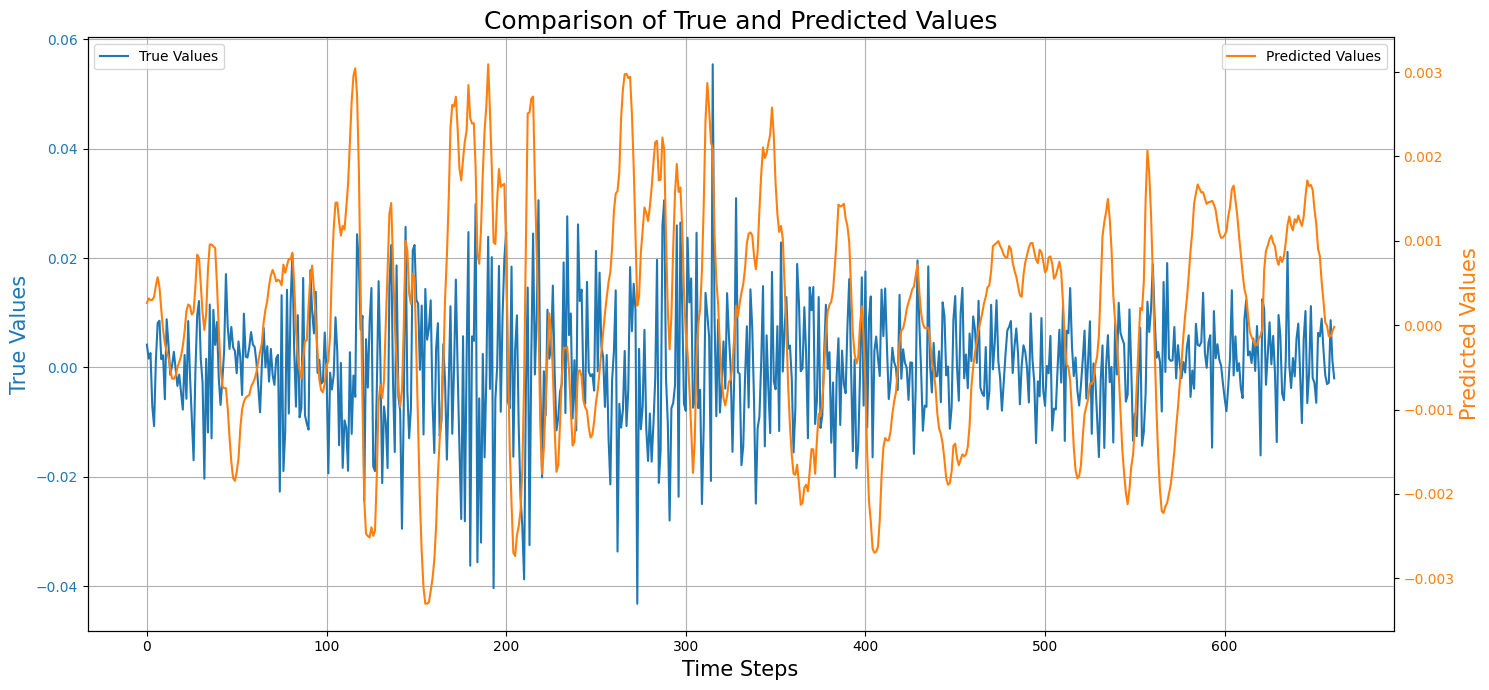

In [ ]:
# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot True Values on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time Steps', fontsize=15)
ax1.set_ylabel('True Values', color=color, fontsize=15)
ax1.plot(y_test_flat, color=color, label='True Values')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for the predicted values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Predicted Values', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(y_pred_flat, color=color, label='Predicted Values')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Final touches
plt.title('Comparison of True and Predicted Values', fontsize=18)
fig.tight_layout() 
plt.show()

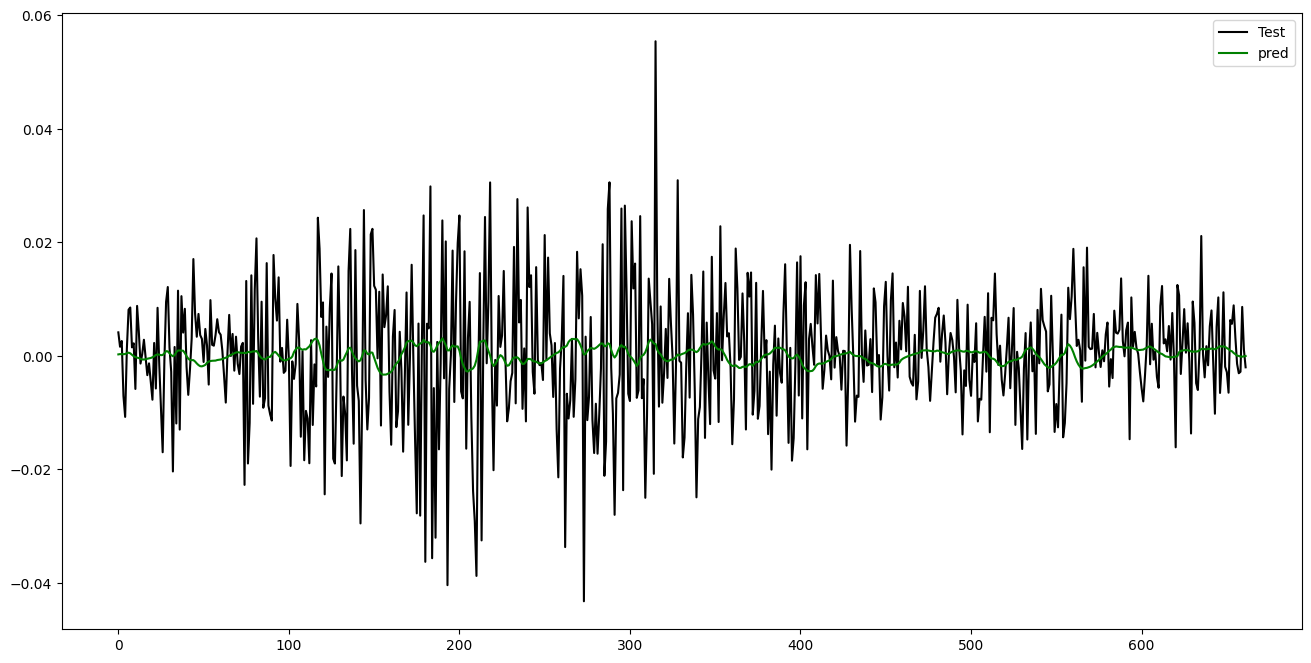

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_flat, color = 'black', label = 'Test')
plt.plot(y_pred_flat, color = 'green', label = 'pred')
plt.legend()
plt.show()

We will then use RandomizedSearchCV to fine-tune the hyperparameters, and let's refer to the resulting model as the "best model2." This process will incorporate the specific hyperparameters that have proven effective in our current model.

In [ ]:
tf.random.set_seed(123)

# Function to create the model
def create_model(units1=65, units2=45, dropout_rate1=0.2, dropout_rate2=0.2, learning_rate=0.00001, input_shape=None):
    model = Sequential([
        LSTM(units=units1, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate1),
        LSTM(units=units2),
        Dropout(dropout_rate2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(
    model=create_model,
    input_shape=(X_train.shape[1], X_train.shape[2]),  # Pass the input shape 
    verbose=0
)

# Define the grid of hyperparameters to search
param_distributions = {
    'model__units1': [32, 64, 128],  # Number of LSTM units in the first layer
    'model__units2': [20, 45, 65],  # Number of LSTM units in the second layer
    'model__dropout_rate1': [0.1, 0.2, 0.3],  # Dropout rate for the first LSTM layer
    'model__dropout_rate2': [0.1, 0.2, 0.3],  # Dropout rate for the second LSTM layer
    'model__learning_rate': [1e-5, 1e-4, 1e-3],  # Learning rate
    'batch_size': [32, 64],  # Batch size
    'epochs': [20, 30, 40]  # Number of epochs
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,  # Number of folds for cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=123
)

# Fit RandomizedSearchCV
random_search_result = random_search.fit(X_train, y_train)

# Output the best score and parameters
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")

# Refit the model with the best parameters
best_model = random_search_result.best_estimator_.model_

# Evaluate the best model on the test set
test_loss, test_rmse, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}, Test MAE: {test_mae}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


2024-08-17 22:05:26.080384: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-17 22:05:26.080415: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-17 22:05:26.080426: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-17 22:05:26.080446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-17 22:05:26.080462: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-17 22:05:26.080490: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-17 22:05:26.080501: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-17 22:05:26.080515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defa

[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.001, model__units1=128, model__units2=65; total time= 1.1min
[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.001, model__units1=128, model__units2=65; total time= 1.1min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=64, model__units2=20; total time= 1.9min
[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 1.9min
[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=64, model__units2=20; total time= 1.9min
[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 1.9min
[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=64, model__units2=20; total time= 1.9min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/qianqianmeng/.virtualenvs/r-retic

[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 1.9min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=64, model__units2=20; total time= 1.2min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.001, model__units1=128, model__units2=65; total time= 1.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=64, model__units2=20; total time=  59.5s


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time=  59.6s


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=64, model__units2=20; total time= 1.0min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 1.0min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 1.1min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=32, model__units2=45; total time= 1.0min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=32, model__units2=45; total time= 1.6min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.0001, model__units1=128, model__units2=20; total time= 1.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=32, model__units2=45; total time= 1.8min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.0001, model__units1=128, model__units2=20; total time= 1.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.0001, model__units1=128, model__units2=20; total time= 1.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=64, model__units2=65; total time= 2.5min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=64, model__units2=65; total time= 2.6min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=64, model__units2=65; total time= 2.6min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__learning_rate=1e-05, model__units1=128, model__units2=65; total time= 2.7min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=32, model__units2=65; total time= 3.1min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__learning_rate=1e-05, model__units1=128, model__units2=65; total time= 2.9min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=32, model__units2=65; total time= 3.0min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__learning_rate=0.0001, model__units1=32, model__units2=65; total time= 3.0min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__learning_rate=1e-05, model__units1=128, model__units2=65; total time= 2.8min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__learning_rate=0.001, model__units1=64, model__units2=20; total time= 3.2min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__learning_rate=0.001, model__units1=64, model__units2=20; total time= 3.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 2.4min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__learning_rate=0.001, model__units1=64, model__units2=20; total time= 3.1min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 2.5min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=64, model__units2=45; total time= 2.2min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.0001, model__units1=128, model__units2=65; total time= 4.1min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 2.7min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.0001, model__units1=128, model__units2=65; total time= 4.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__learning_rate=0.0001, model__units1=128, model__units2=65; total time= 4.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=64, model__units2=45; total time= 2.5min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=64, model__units2=45; total time= 2.4min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=1e-05, model__units1=64, model__units2=65; total time= 2.9min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=1e-05, model__units1=64, model__units2=65; total time= 2.8min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=1e-05, model__units1=64, model__units2=65; total time= 2.8min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 3.1min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 3.2min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__learning_rate=0.001, model__units1=32, model__units2=20; total time= 3.3min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__learning_rate=0.0001, model__units1=32, model__units2=20; total time= 2.6min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__learning_rate=0.0001, model__units1=32, model__units2=20; total time= 2.8min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=128, model__units2=20; total time= 4.6min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=128, model__units2=20; total time= 4.6min


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__learning_rate=0.0001, model__units1=32, model__units2=20; total time= 2.7min
[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__learning_rate=0.001, model__units1=64, model__units2=45; total time= 2.8min
[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__learning_rate=0.001, model__units1=64, model__units2=45; total time= 2.7min
[CV] END batch_size=32, epochs=40, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__learning_rate=1e-05, model__units1=128, model__units2=20; total time= 3.9min
[CV] END batch_size=32, epochs=20, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__learning_rate=0.0001, model__units1=32, model__units2=20; total time= 1.1min
[CV] END batch_size=64, epochs=40, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__learning_rate=0.001, model__units1=64, model__units2=

/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: -0.04473649644605201 using {'model__units2': 45, 'model__units1': 64, 'model__learning_rate': 0.001, 'model__dropout_rate2': 0.2, 'model__dropout_rate1': 0.3, 'epochs': 40, 'batch_size': 64}
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3915e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0116
Test Loss: 0.00012966938083991408, Test RMSE: 0.011387246660888195, Test MAE: 0.008528448641300201


Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0028 - mean_absolute_error: 0.0393 - root_mean_squared_error: 0.0522 - val_loss: 3.6854e-04 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0192 - learning_rate: 0.0010
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.9041e-04 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0242 - val_loss: 3.5747e-04 - val_mean_absolute_error: 0.0129 - val_root_mean_squared_error: 0.0189 - learning_rate: 0.0010
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.4724e-04 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0186 - val_loss: 2.8347e-04 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0168 - learning_rate: 0.0010
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7914e-04 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0167 - val_loss: 3.1600e-04 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0178 - learning_rate:

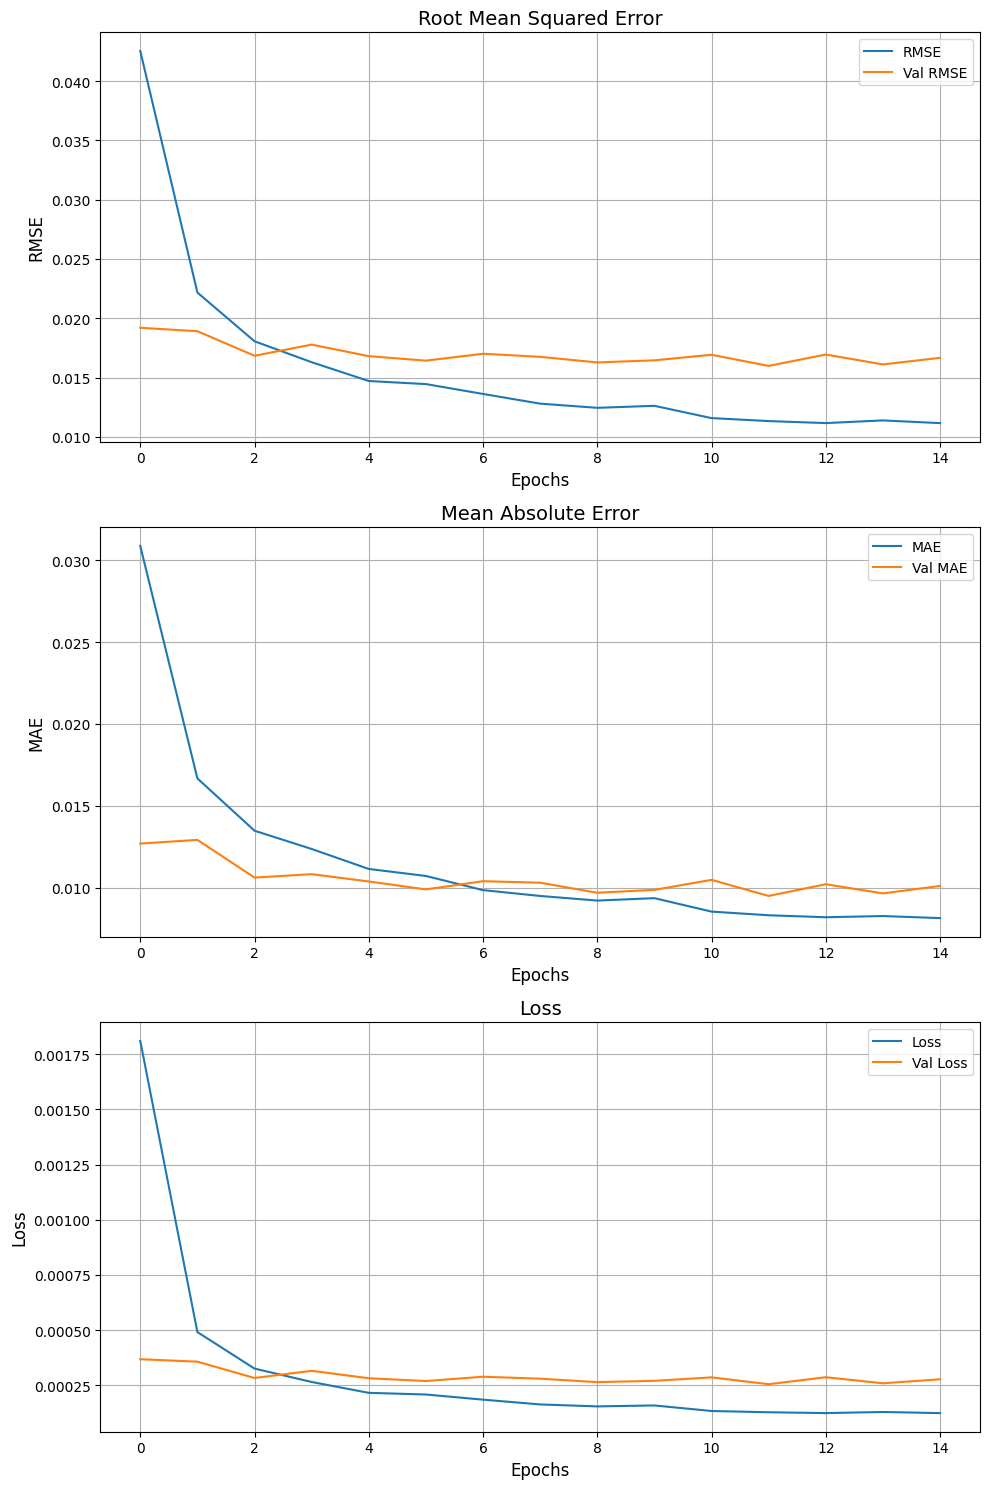

In [ ]:
# Retrieve the best parameters from RandomizedSearchCV
best_params = random_search_result.best_params_

# Create a new model with the best parameters
best_model2 = create_model(
    units1=best_params['model__units1'],
    units2=best_params['model__units2'],
    dropout_rate1=best_params['model__dropout_rate1'],  
    dropout_rate2=best_params['model__dropout_rate2'],  
    learning_rate=best_params['model__learning_rate'],
    input_shape=(X_train.shape[1], X_train.shape[2])
)

# Fit the model with the best parameters and capture the history
history = best_model2.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.2,
                         callbacks=[es, model_checkpoint, reduce_lr])

# Check metric names
print(history.history.keys())  

# Plotting the RMSE, MAE, and Loss
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# RMSE plot
ax1.plot(history.epoch, history.history['root_mean_squared_error'], label="RMSE")
ax1.plot(history.epoch, history.history['val_root_mean_squared_error'], label="Val RMSE")
ax1.set_title("Root Mean Squared Error", fontsize=14)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("RMSE", fontsize=12)
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(history.epoch, history.history['mean_absolute_error'], label="MAE")
ax2.plot(history.epoch, history.history['val_mean_absolute_error'], label="Val MAE")
ax2.set_title("Mean Absolute Error", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("MAE", fontsize=12)
ax2.legend()
ax2.grid(True)

# Loss plot
ax3.plot(history.epoch, history.history['loss'], label="Loss")
ax3.plot(history.epoch, history.history['val_loss'], label="Val Loss")
ax3.set_title("Loss", fontsize=14)
ax3.set_xlabel("Epochs", fontsize=12)
ax3.set_ylabel("Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


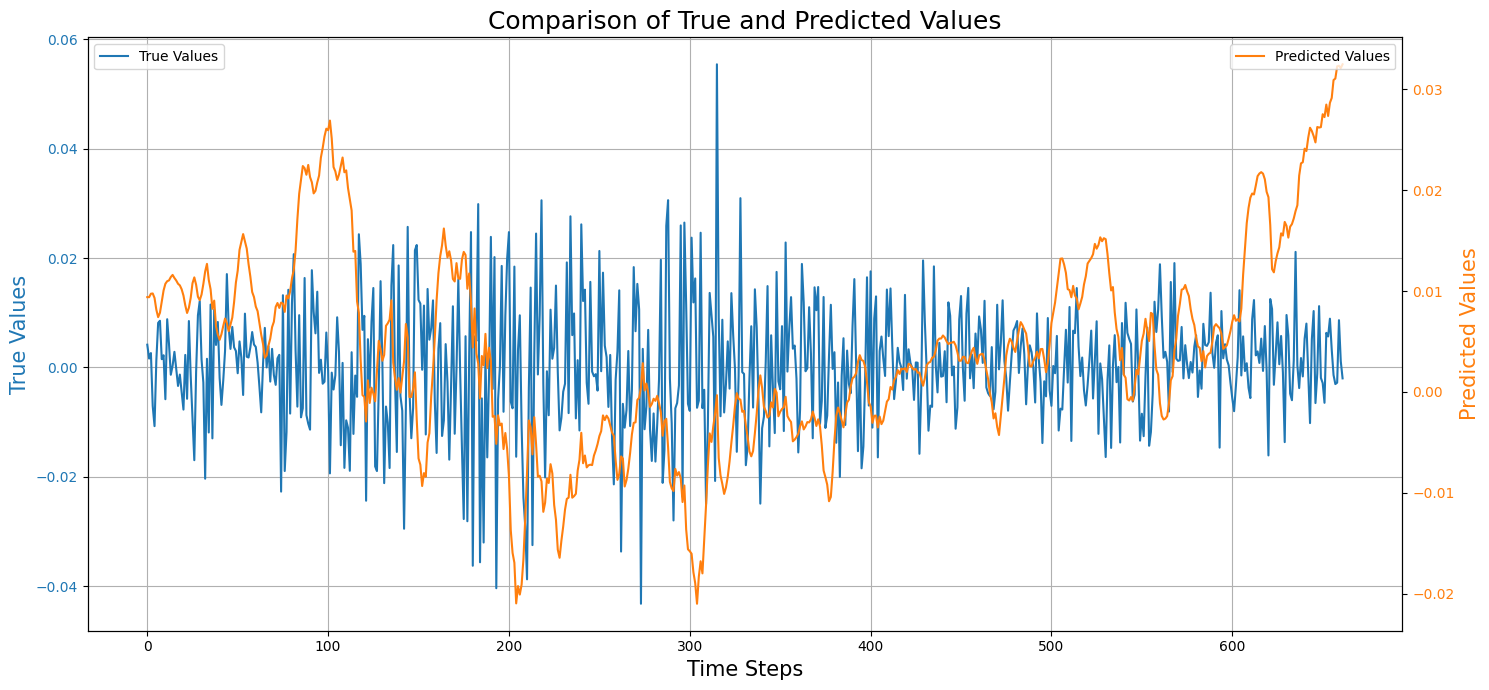

In [ ]:
y_pred = best_model2.predict(X_test)

y_test_flat = y_test.flatten() # into a 1D array (a flat array)
y_pred_flat = y_pred.flatten()

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot True Values on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time Steps', fontsize=15)
ax1.set_ylabel('True Values', color=color, fontsize=15)
ax1.plot(y_test_flat, color=color, label='True Values')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for the predicted values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Predicted Values', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(y_pred_flat, color=color, label='Predicted Values')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')


plt.title('Comparison of True and Predicted Values', fontsize=18)
fig.tight_layout() 
plt.show()

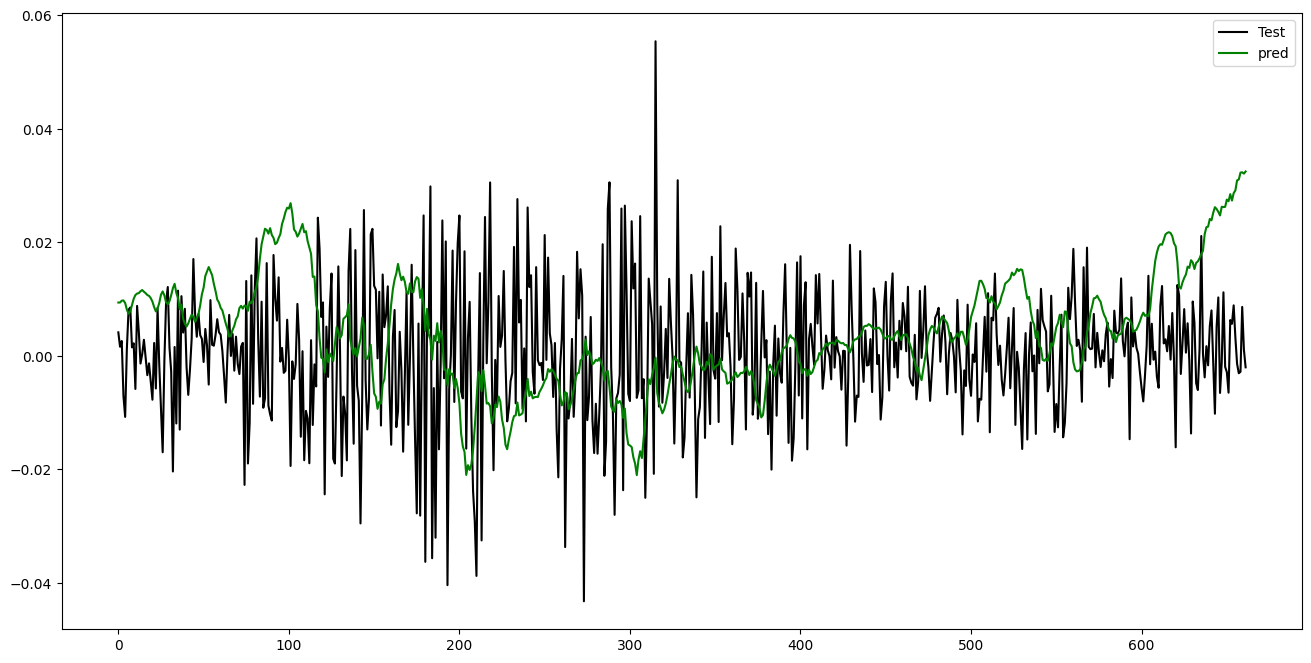

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_flat, color = 'black', label = 'Test')
plt.plot(y_pred_flat, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [ ]:
best_params

{'model__units2': 45,
 'model__units1': 64,
 'model__learning_rate': 0.001,
 'model__dropout_rate2': 0.2,
 'model__dropout_rate1': 0.3,
 'epochs': 40,
 'batch_size': 64}

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0031 - mean_absolute_error: 0.0406 - root_mean_squared_error: 0.0553 - val_loss: 5.4460e-04 - val_mean_absolute_error: 0.0184 - val_root_mean_squared_error: 0.0233 - learning_rate: 0.0010
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2124e-04 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0249 - val_loss: 4.7393e-04 - val_mean_absolute_error: 0.0146 - val_root_mean_squared_error: 0.0218 - learning_rate: 0.0010
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.2424e-04 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0206 - val_loss: 3.2481e-04 - val_mean_absolute_error: 0.0129 - val_root_mean_squared_error: 0.0180 - learning_rate: 0.0010
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8669e-04 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0169 - val_loss: 2.6562e-04 - val_mean_absolute_error: 0.0097 - val_root_mean_squared_error: 0.0163 - learning_rate:

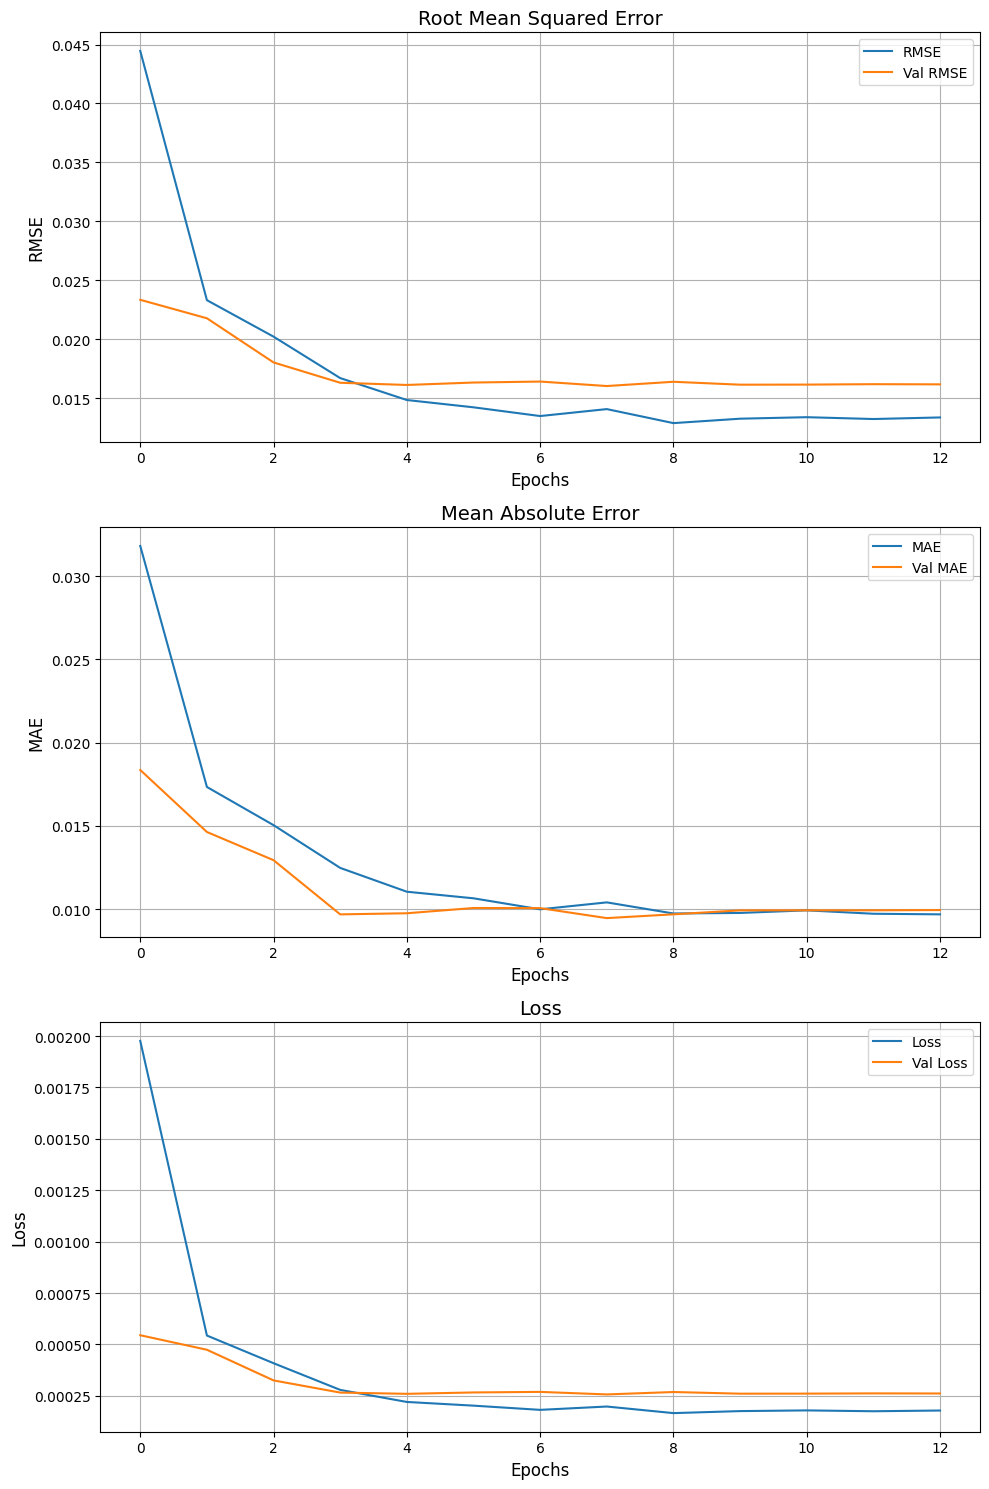

In [ ]:
tf.random.set_seed(123)

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(units=45),
    Dropout(0.2),
    Dense(1)
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', 
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

# Callbacks for early stopping, model checkpointing, and learning rate reduction
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Fit the model with callbacks
history = model.fit(X_train, y_train, epochs=40, batch_size=64, 
                    validation_split=0.2,
                    callbacks=[es, model_checkpoint, reduce_lr])

# Load the best model based on validation loss
model.load_weights('best_model.keras')

# Plotting the RMSE, MAE, and Loss
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# RMSE plot
ax1.plot(history.epoch, history.history['root_mean_squared_error'], label="RMSE")
ax1.plot(history.epoch, history.history['val_root_mean_squared_error'], label="Val RMSE")
ax1.set_title("Root Mean Squared Error", fontsize=14)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("RMSE", fontsize=12)
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(history.epoch, history.history['mean_absolute_error'], label="MAE")
ax2.plot(history.epoch, history.history['val_mean_absolute_error'], label="Val MAE")
ax2.set_title("Mean Absolute Error", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("MAE", fontsize=12)
ax2.legend()
ax2.grid(True)

# Loss plot
ax3.plot(history.epoch, history.history['loss'], label="Loss")
ax3.plot(history.epoch, history.history['val_loss'], label="Val Loss")
ax3.set_title("Loss", fontsize=14)
ax3.set_xlabel("Epochs", fontsize=12)
ax3.set_ylabel("Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)

y_test_flat = y_test.flatten() # into a 1D array (a flat array)
y_pred_flat = y_pred.flatten()


test_loss, test_rmse, test_mae = best_model1.evaluate(X_test, y_test)


print(f"Test Loss: {round(test_loss, 5)}, Test RMSE: {round(test_rmse, 5)}, Test MAE: {round(test_mae, 5)}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3794e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.3794e-04
Test Loss: 0.00013, Test RMSE: 0.00013, Test MAE: 0.00851


In [ ]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[-0.00058111] [0.00414638]
[-0.0014018] [0.00160731]
[-0.00160498] [0.00262085]
[-0.00182355] [-0.0070607]
[-0.00116957] [-0.01074847]
[-0.00093944] [0.00125669]
[-0.00147011] [0.00814157]
[-0.0022076] [0.00852379]
[-0.00281608] [0.00149574]
[-0.00203271] [0.00222012]


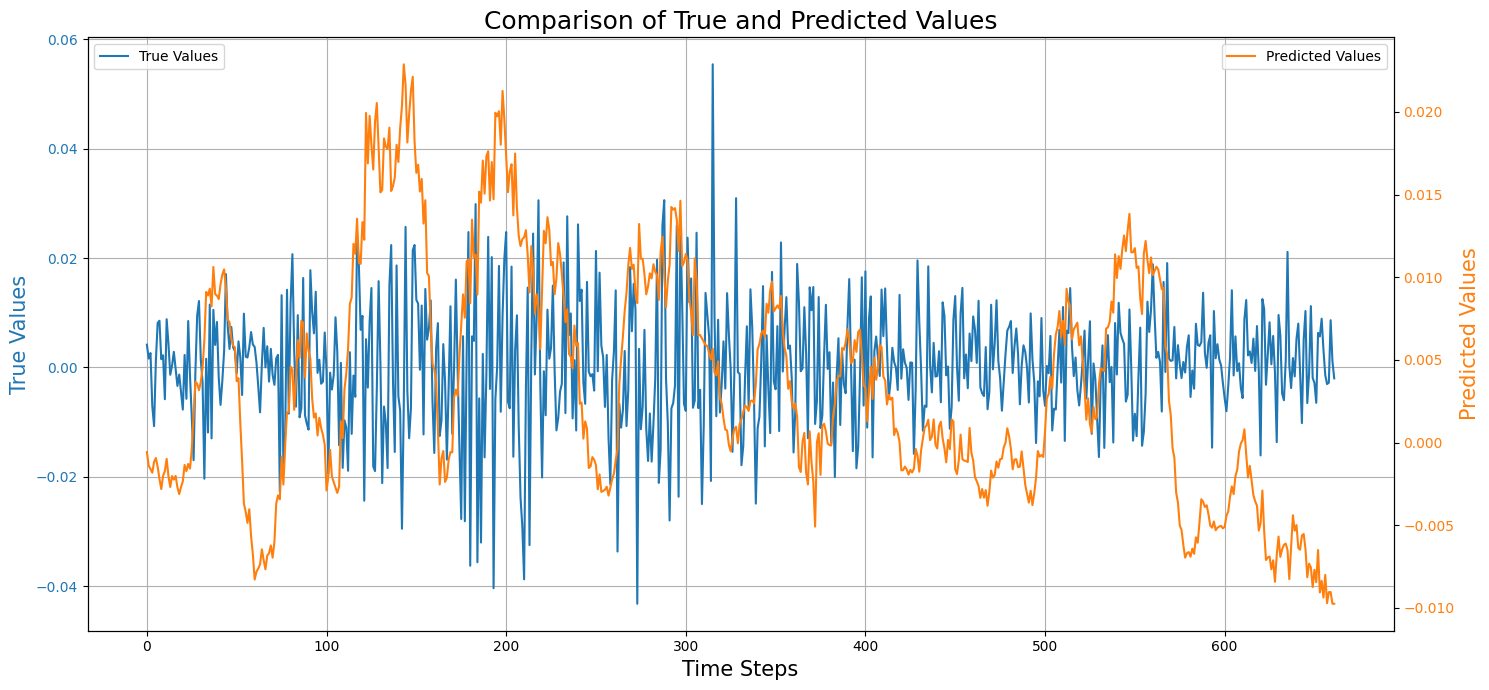

In [ ]:
# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot True Values on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time Steps', fontsize=15)
ax1.set_ylabel('True Values', color=color, fontsize=15)
ax1.plot(y_test_flat, color=color, label='True Values')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for the predicted values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Predicted Values', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(y_pred_flat, color=color, label='Predicted Values')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Final touches
plt.title('Comparison of True and Predicted Values', fontsize=18)
fig.tight_layout() 
plt.show()

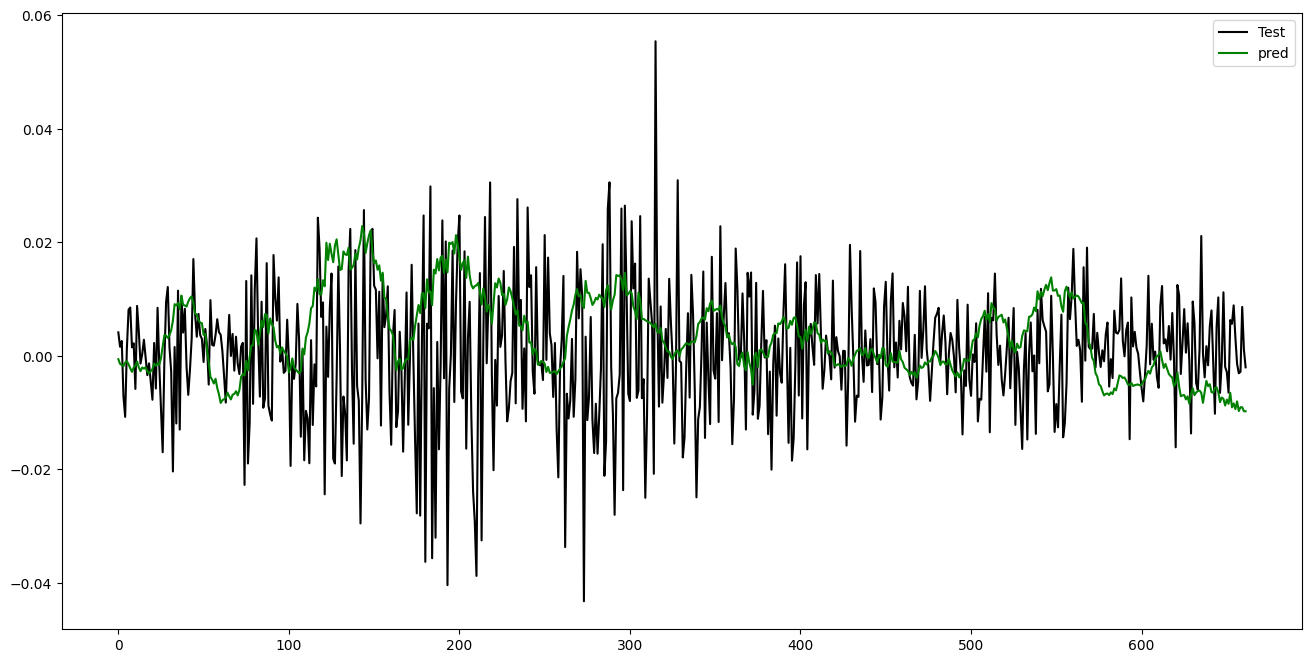

In [ ]:
 
plt.figure(figsize=(16,8))
plt.plot(y_test_flat, color = 'black', label = 'Test')
plt.plot(y_pred_flat, color = 'green', label = 'pred')
plt.legend()
plt.show()

Reference:
https://www.investopedia.com/ask/answers/08/find-stocks-in-sp500.asp [The Top 25 Stocks in the S&P 500]